In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

Dataset creation

In [2]:
df = pd.read_parquet(r"C:\Users\adrie\OneDrive\Documents\EPFL\ML\Project 2\All_Relative_Results_Cleaned.parquet")

In [3]:
df.head(3)

,Participant,Exercise,Set,Camera,time(s),left_ankle_x,left_ankle_y,left_ankle_z,left_ear_x,left_ear_y,...,right_pinky_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_thumb_x,right_thumb_y,right_thumb_z,right_wrist_x,right_wrist_y,right_wrist_z
0,P04,Abduction,Correct,Frontal_Top,0.000,0.009328,0.779305,0.187880,0.020658,-0.693419,...,-0.633111,-0.054347,-0.511760,-0.185118,-0.068159,-0.602015,-0.598093,-0.066565,-0.600690,-0.592768
1,P04,Abduction,Correct,Frontal_Top,0.033,0.009353,0.779298,0.185050,0.021187,-0.693361,...,-0.630835,-0.054293,-0.511703,-0.184861,-0.068130,-0.602200,-0.596219,-0.066508,-0.600835,-0.590916
2,P04,Abduction,Correct,Frontal_Top,0.067,0.009722,0.779311,0.179212,0.021351,-0.693388,...,-0.630923,-0.054289,-0.511696,-0.184849,-0.067241,-0.601852,-0.596222,-0.065676,-0.600436,-0.590910


In [4]:
df['Camera'].unique()

array(['Frontal_Top', 'Frontal_Low', 'Side_Top'], dtype=object)

In [3]:
df_clean = df.dropna()
index = df_clean.columns.get_loc('time(s)')
df_right = df_clean.iloc[:, index+1:]
X = df_right
Y = df_clean['Exercise']

In [4]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

In [5]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(Y_encoded, dtype=torch.long)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

train_dataset = TensorDataset(X_train,Y_train)
test_dataset = TensorDataset(X_test,Y_test)
trainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=32 , shuffle=True)

**Neural network architecture**

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64,128)
        self.layer3 = nn.Linear(128,256)
        self.layer4 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        return x

model = NeuralNetwork()

**Training configuration**

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Model training**

In [27]:
model.train()

for epoch in range(10):  # 4 is the nbr of epochs
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for inputs, labels in trainLoader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculer la perte moyenne et l'exactitude pour l'époque
    epoch_loss = running_loss / len(trainLoader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Époque {epoch + 1}, Perte: {epoch_loss:.4f}, Exactitude: {epoch_accuracy:.2f}%')


Époque 1, Perte: 0.1742, Exactitude: 92.68%
Époque 2, Perte: 0.1421, Exactitude: 93.93%
Époque 3, Perte: 0.1322, Exactitude: 94.37%
Époque 4, Perte: 0.1262, Exactitude: 94.66%
Époque 5, Perte: 0.1227, Exactitude: 94.85%
Époque 6, Perte: 0.1203, Exactitude: 94.97%
Époque 7, Perte: 0.1190, Exactitude: 95.05%
Époque 8, Perte: 0.1179, Exactitude: 95.12%
Époque 9, Perte: 0.1170, Exactitude: 95.17%
Époque 10, Perte: 0.1162, Exactitude: 95.23%


**Model testing**

In [28]:
model.eval()  # Mettre le modèle en mode évaluation
total_test = 0
correct_test = 0

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testLoader:
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Exactitude sur l\'ensemble de test: {test_accuracy}%')


Exactitude sur l'ensemble de test: 94.8273097888324%


**Confusion matrix visualization**

Text(52.722222222222214, 0.5, 'True labels')

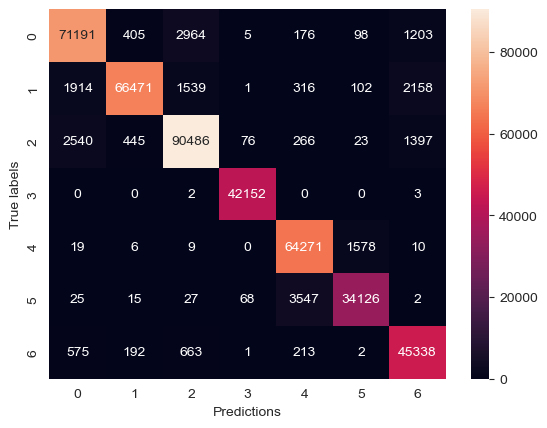

In [29]:
conf_matrix = confusion_matrix(y_true,y_pred)

sns.heatmap(conf_matrix, annot=True, fmt = 'd')
plt.xlabel('Predictions')
plt.ylabel('True labels')

**Classification report**

In [30]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     76042
           1       0.98      0.92      0.95     72501
           2       0.95      0.95      0.95     95233
           3       1.00      1.00      1.00     42157
           4       0.93      0.98      0.95     65893
           5       0.95      0.90      0.93     37810
           6       0.90      0.96      0.93     46984

    accuracy                           0.95    436620
   macro avg       0.95      0.95      0.95    436620
weighted avg       0.95      0.95      0.95    436620


**Convolutionnal Neural network**

Data preprocessing

In [67]:
nbr_of_points = (X.shape[1])//3
X_reshape = X.values.reshape(-1,3,nbr_of_points)
tensor_4D = np.transpose(X_reshape, (0, 2, 1))

tensor_4D = np.expand_dims(tensor_4D, axis=3)
tensor_4D_transposed = np.expand_dims(tensor_4D, axis=4)

print(tensor_4D_transposed.shape)

(2183099, 33, 3, 1, 1)


In [80]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=33, out_channels=64, kernel_size=(3,1,1), stride=1, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(1,1,1), stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=128, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

modelCNN = ConvNeuralNetwork()

CNN config

In [84]:
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(modelCNN.parameters(), lr = 0.001)

In [82]:
scheduler_cnn = torch.optim.lr_scheduler.StepLR(optimizer_cnn, step_size=30, gamma=0.1)

Training Cnn

In [70]:
X_tensor_cnn= torch.tensor(tensor_4D_transposed).float()
Y_tensor_cnn = y_tensor
X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(X_tensor_cnn, Y_tensor_cnn, test_size=0.2)
print(X_train_cnn.shape)
dataset_train_cnn = TensorDataset(X_train_cnn, Y_train_cnn)
trainLoader_cnn = DataLoader(dataset_train_cnn, batch_size=33, shuffle=True)
dataset_test_cnn = TensorDataset(X_test_cnn, Y_test_cnn)
testLoader_cnn = DataLoader(dataset_test_cnn, batch_size=32, shuffle=True)

torch.Size([1746479, 33, 3, 1, 1])


In [87]:
num_epochs = 4  # ou le nombre d'époques souhaité
modelCNN.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in trainLoader_cnn:
        optimizer_cnn.zero_grad()            
        outputs = modelCNN(inputs)          
        loss = criterion_cnn(outputs, labels)  
        loss.backward()                  
        optimizer_cnn.step()
        
        running_loss += loss.item()
    
    if scheduler_cnn:
        scheduler_cnn.step() 

    print(f"Époque {epoch + 1}/{num_epochs}, Perte : {running_loss / len(trainLoader_cnn)}")


KeyboardInterrupt: 

Transformers